# 1.4 - Stopping Criteria

In [3]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [5]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

import numpy as np
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
import corner

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

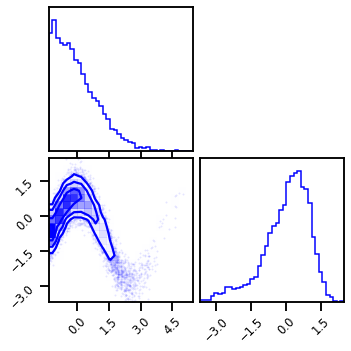

In [6]:
from rbig_jax.data import get_classic
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 10_000
n_features = 2
data = get_classic(n_samples, seed=123)
data = StandardScaler().fit_transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [7]:
X = np.array(data, dtype=np.float32)

## Gaussianization Flow Model

In [8]:
from rbig_jax.transforms.block import init_default_rbig_block

n_samples = X.shape[0]
support_extension = 10
alpha = 1e-5
precision = 100
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = False
eps = 1e-5

# init rbig_block
rbig_block = init_default_rbig_block(
    shape=X.shape,
    support_extension=support_extension,
    alpha=alpha,
    precision=precision,
    nbins=nbins,
    jitted=jitted,
    eps=eps,
)

In [9]:
# from rbig_jax.transforms.histogram import InitUniHistTransform
# from rbig_jax.transforms.logit import InitLogitTransform, InitSigmoidTransform

# # ==================
# # Layer I - Sigmoid
# # ==================
# jitted = True

# init_sigmoid_f = InitSigmoidTransform(jitted=jitted)

# # =====================
# # Layer II - Histogram
# # =====================

# # KDE Transform
# support_extension = 0.001
# alpha = 1e-5
# precision = 1_000
# jitted = True

# n_samples = X.shape[0]
# nbins = int(jnp.sqrt(n_samples))

# init_hist_f = InitUniHistTransform(
#     n_samples=X.shape,
#     support_extension=support_extension,
#     precision=precision,
#     nbins=nbins,
#     jitted=jitted,
# )

# # ====================
# # Layer III - Sigmoid
# # ====================

# from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# # univariate normalization Gaussianization parameters
# init_logit_f = InitLogitTransform(jitted=jitted)

# from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# # univariate normalization Gaussianization parameters
# eps = 1e-5

# # initialize histogram transformation
# init_icdf_f = InitInverseGaussCDFTransform(eps=eps, jitted=jitted)


# # =====================
# # Layer IV - Rotation
# # =====================

# from rbig_jax.transforms.rotation import InitPCARotation

# # initialize histogram transformation
# init_pca_f = InitPCARotation(jitted=jitted)


# # initialize rbig block
# init_functions = [init_sigmoid_f, init_hist_f, init_icdf_f, init_pca_f]

# from rbig_jax.transforms.block import RBIGBlock

# rbig_block = RBIGBlock(init_functions=init_functions)

In [10]:
# from rbig_jax.transforms.kde import InitUniKDETransform

# # KDE Transform
# support_extension = 20
# alpha = 1e-5
# precision = 1_000
# bw = "scott"  # estimate_bw(X.shape[0], 1, "scott")
# jitted = True

# init_hist_f = InitUniKDETransform(
#     shape=X.shape,
#     support_extension=support_extension,
#     precision=precision,
#     bw=bw,
#     jitted=jitted,
# )

# from rbig_jax.transforms.inversecdf import InitInverseGaussCDFTransform

# # univariate normalization Gaussianization parameters
# eps = 1e-5

# # initialize histogram transformation
# init_icdf_f = InitInverseGaussCDFTransform(eps=eps, jitted=jitted)

# from rbig_jax.transforms.rotation import InitPCARotation

# # initialize histogram transformation
# init_pca_f = InitPCARotation(jitted=True)


# # initialize rbig block
# init_functions = [init_hist_f, init_icdf_f, init_pca_f]

# from rbig_jax.transforms.block import RBIGBlock

# rbig_block = RBIGBlock(init_functions=init_functions)

## Training

### Fixed Number of Layers

In [11]:
from rbig_jax.training.iterative import train_max_layers_model

# initialize the max layers parameters
max_layers = 30
verbose = True
interval = 10

# run iterative training
X_g, rbig_model = train_max_layers_model(
    X=X,
    rbig_block=rbig_block,
    verbose=verbose,
    interval=interval,
    max_layers=max_layers,
)

Layer 10 - Elapsed Time: 5.4431
Layer 20 - Elapsed Time: 7.7872
Layer 30 - Elapsed Time: 10.0848
Completed.
Final Number of layers: 30 (Blocks: 10)
Elapsed Time: 10.0848


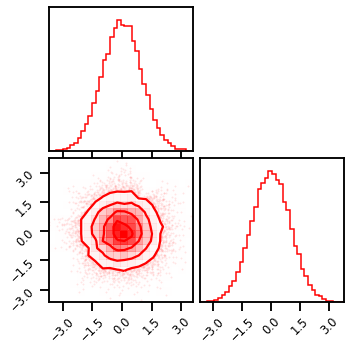

In [12]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

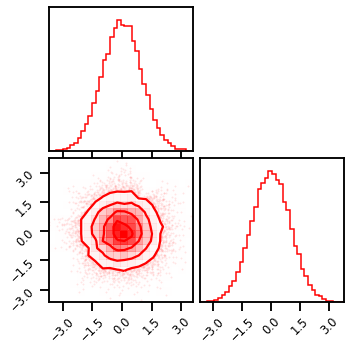

In [13]:
# inverse cascade
X_g_ = rbig_model.forward(X)

# plot
fig = corner.corner(X_g_, color="red", hist_bin_factor=2)

### Information Reduction

### Information Loss

In [14]:
from rbig_jax.transforms.block import init_default_rbig_block

n_samples = X.shape[0]
support_extension = 10
alpha = 1e-1
precision = 100
nbins = None  # init_bin_estimator("sqrt") #bins #cott"#int(np.sqrt(X.shape[0]))
jitted = True
eps = 1e-5
method = "kde"
bw = "scott"  # init_bin_estimator("sqrt")

# init rbig_block
rbig_block = init_default_rbig_block(
    shape=X.shape,
    support_extension=support_extension,
    alpha=alpha,
    precision=precision,
    nbins=nbins,
    jitted=jitted,
    eps=eps,
    method=method,
)

In [16]:
from rbig_jax.training.iterative import train_info_loss_model
from rbig_jax.losses import init_info_loss

# define loss parameters
max_layers = 200
zero_tolerance = 60
p = 0.25
base = 2
jitted = True

# initialize info loss function
loss = init_info_loss(
    n_samples=X.shape[0],
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    base=base,
    jitted=jitted,
)

# define training params
verbose = True
n_layers_remove = 40
interval = 5

# run iterative training
X_g, rbig_model = train_info_loss_model(
    X=X,
    rbig_block=rbig_block,
    loss=loss,
    verbose=verbose,
    interval=10,
    n_layers_remove=n_layers_remove,
)

Layer 10 - Cum. Info Reduction: 0.550 - Elapsed Time: 2.2326
Layer 20 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.3346
Layer 30 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.4358
Layer 40 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.5371
Layer 50 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.6383
Layer 60 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.7327
Layer 70 - Cum. Info Reduction: 0.573 - Elapsed Time: 2.8218
Converged at Layer: 73
Final Number of layers: 33 (Blocks: 11)
Total Time: 2.8518


#### Final Loss

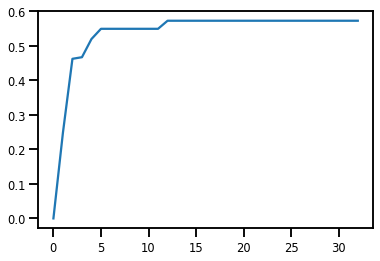

In [17]:
plt.plot(np.cumsum(rbig_model.info_loss))
plt.show()

#### Visualize

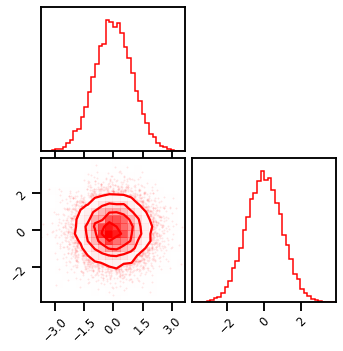

In [18]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)

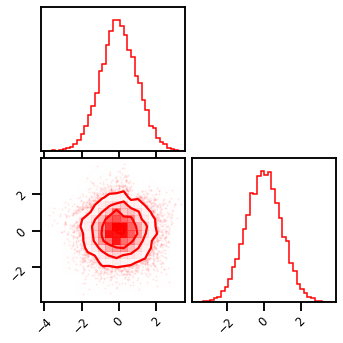

In [19]:
# inverse cascade
X_g_ = rbig_model.forward(X)

# plot
fig = corner.corner(X_g_, color="red", hist_bin_factor=2)

#### Inverse Transformation

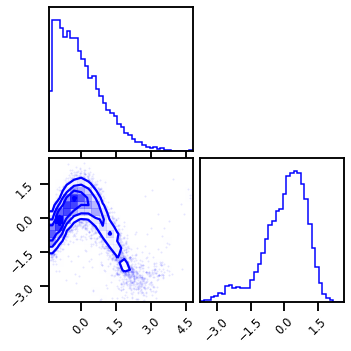

In [20]:
# inverse cascade
X_approx = rbig_model.inverse(X_g)

# plot
fig = corner.corner(X_approx, color="blue", hist_bin_factor=2)

#### Density Estimation

In [21]:
from rbig_jax.data import generate_2d_grid

In [25]:
# generate inputs
xyinput = generate_2d_grid(X, 500, buffer=0.1)

X_log_prob = rbig_model.score_samples(xyinput)

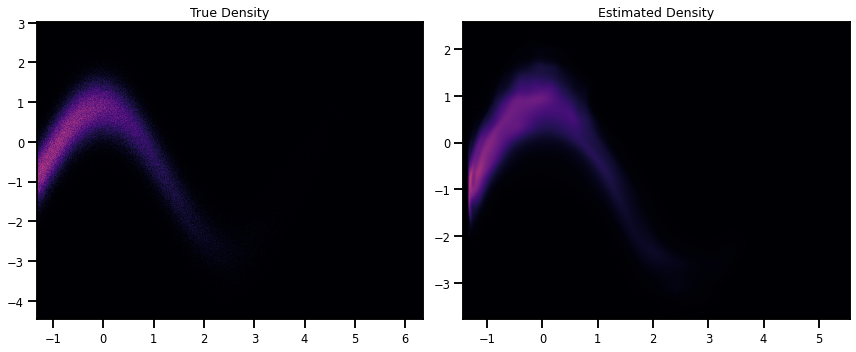

In [26]:
from matplotlib import cm

# Original Density
n_samples = 1_000_000
n_features = 2
X_plot = get_classic(n_samples, seed=123)
X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

#### Generate Samples

In [34]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 5.23 s, sys: 330 ms, total: 5.56 s
Wall time: 3.07 s


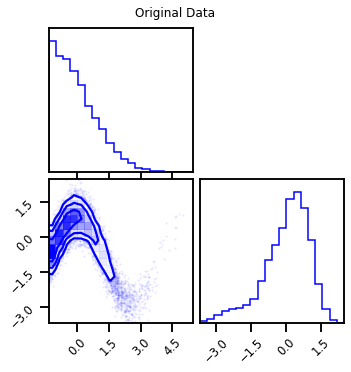

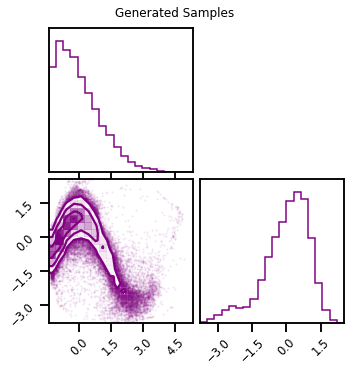

In [35]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Loading and Saving

In [27]:
import pickle

with open("rbig_model.pickle", "wb") as f:
    pickle.dump(rbig_model, f)

### Saving

In [28]:
with open("rbig_model.pickle", "rb") as f:
    rbig_model_ = pickle.load(f)

In [32]:
nll = rbig_model_.score(X)
print(nll)

1.9014244


## Negative Log-Likelihood

#### Loss Function

In [25]:
# @jax.jit
# def nll_loss(X_gauss, X_ldj):
#     latent_prob = jax.scipy.stats.norm.logpdf(X_g)

#     log_prob = (latent_prob + X_ldj).sum(-1)
#     return - log_prob.mean()

#### Training

In [26]:
# %%time

# X_g_ = X
# X_ldj = np.zeros_like(X)
# nll_losses = []
# for iparam in params:

#     X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
#     X_ldj += iX_ldj

#     nll_losses.append(nll_loss(X_g_, X_ldj))

# chex.assert_tree_all_close(X_g_, X_g)

#### Plot Losses

In [27]:
# plt.figure()
# plt.plot(nll_losses)
# plt.title('Negative Log-Likelihood')
# plt.show()

### Negative Log-Likelihood (Change per layer)

In [28]:
# %%time

# X_g_ = X
# X_ldj = np.zeros_like(X)
# nll_change_losses = []
# for iparam in params:

#     X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
#     X_ldj += iX_ldj

#     nll_change_losses.append(nll_loss(X_g_, iX_ldj))

# chex.assert_tree_all_close(X_g_, X_g)

In [29]:
# plt.figure()
# plt.plot(nll_change_losses)
# plt.title('Change in Log-Likelihood')
# plt.show()